In [178]:
import scipy.stats
from scipy.stats import binned_statistic as bs
import sklearn.linear_model
from sklearn.linear_model import LogisticRegression as lr 
from sklearn.metrics import auc
import pandas as pd
import numpy as np
import os

FILE_PATH = os.path.join("datasets", "ps3")

# Function to load numpy arrays
def load_file_data(file_name, file_path=FILE_PATH):
    os.makedirs(file_path, exist_ok=True)
    numpy_path = os.path.join(file_path, file_name)
    return np.load(numpy_path)

In [179]:
import random

# Store patient Z and genetic fingerprints
genetics = load_file_data("ps3_genetic_fingerprints.npy")
patient = load_file_data("ps3_patient_zet.npy")

In [180]:
from sklearn.decomposition import PCA

# Run PCA to reduce dimensionality of genetic fingerprint from 386
pca = PCA()
pca.fit(genetics)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

32

In [181]:
# Run PCA to conserve 95% of the training set's variance
# This will reduce dimensions to 32
pca = PCA(n_components=.95)
X_reduced = pca.fit_transform(genetics)
X_reduced.shape

(14398, 32)

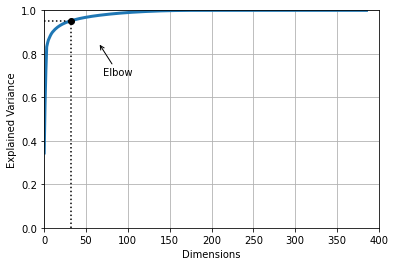

In [182]:
%matplotlib inline
import matplotlib.pyplot as plt

# We can observe the variance maintained for different dimensions, revealing 32 preserves most of it
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=10)
plt.grid(True)
plt.show()

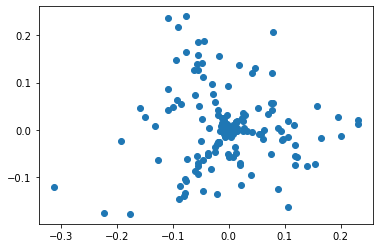

In [204]:
# Scatter plot of the first and second principal components of the reduced genetic fingerprints
plt.scatter(pca.components_.T[:, 0], pca.components_.T[:, 1])

In [203]:
from sklearn.cluster import KMeans

# From data following we know 5 clusters is optimal so Kmeans is run on the data
k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X_reduced)

In [184]:
y_pred

array([4, 2, 3, ..., 4, 2, 0], dtype=int32)

In [185]:
# Determines inertia levels for different values of k
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X_reduced)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

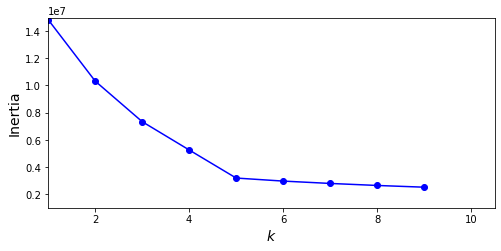

In [186]:
# Shows an elbow at k=5 after which inertia is not decreased much
# k < 5 could lead to bad groups and k > 5 could split groups in half
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

plt.axis([1, 10.5, 1000000, 15000000])
plt.show()

In [187]:
from sklearn.metrics import silhouette_score

# Compute th silhouette score for different k to ensure 5 is correct number
silhouette_scores = [silhouette_score(X_reduced, model.labels_)
                     for model in kmeans_per_k[1:]]

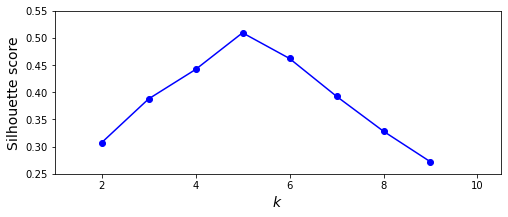

In [188]:
# Plot shows that k=5 givs the highest silhouette score
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1, 10.5, 0.25, 0.55])

plt.show()

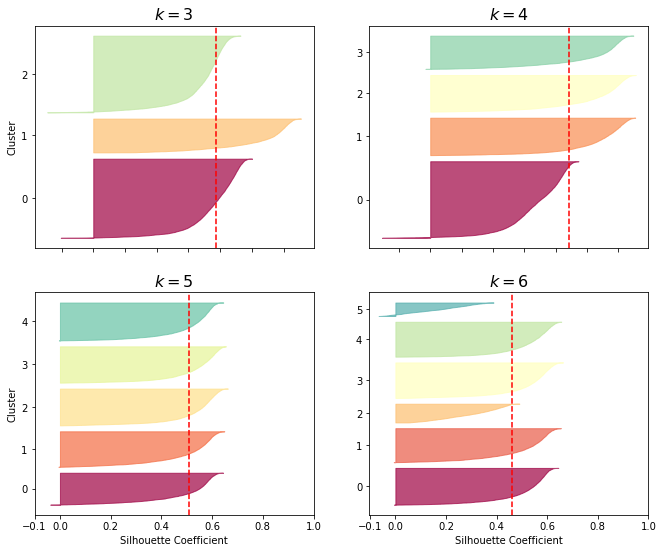

In [189]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl

# This silhouette diagram further cements k=5 being the best choice and shows the model is very balanced 
plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X_reduced, y_pred)

    padding = len(X_reduced) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

In [190]:
# Now that we have our clusters we can predict where patient Z belongs
patient_reduced = pca.transform(patient.reshape(1,-1))
prediction = kmeans.predict(patient_reduced)
prediction

array([1], dtype=int32)

In [191]:
# Count the number of patients within each group to know how many belong with patient Z
group0 = 0
group1 = 0
group2 = 0
group3 = 0
group4 = 0
for x in y_pred:
    if x == 0:
        group0 += 1
    elif x == 1:
        group1 += 1
    elif x == 2:
        group2 += 1
    elif x == 3:
        group3 += 1
    elif x == 4:
        group4 += 1

print("Group 0: ", group0, "\nGroup 1: ", group1, "\nGroup 2: ", group2, "\nGroup 3: ", group3, "\nGroup 4: ", group4)

Group 0:  3055 
Group 1:  2821 
Group 2:  1553 
Group 3:  2951 
Group 4:  2898


In [192]:
# Write data to csv file with patients in patient Z's group receiving values of 1 
import csv
with open('ps3.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(["Id", "Predicted"])
    for i, x in enumerate(y_pred):
        if x == 1:
            writer.writerow([i, "1"])
        else:
            writer.writerow([i, "0"])